In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Inference using `fastai`

### Load Data, Model

In [2]:
from fastai.vision import *
from CinemaNet.convert import torch_to_onnx
from CinemaNet.custom_head import *

In [3]:
data = ImageDataBunch.from_folder('/home/rahul/github_projects/CinemaNet/',
                                  size=(224,224), resize_method=ResizeMethod.SQUISH,
                                  ds_tfms=get_transforms(max_zoom=1.)).normalize(imagenet_stats)
arch = models.mobilenet_v2

In [4]:
learn = cnn_learner(data, arch)
learn.load('/home/rahul/bestmodel');

In [5]:
np.random.seed(42)
samples = (list(learn.data.valid_ds.items)); np.random.shuffle(samples)
samples = samples[:5]

### Inference

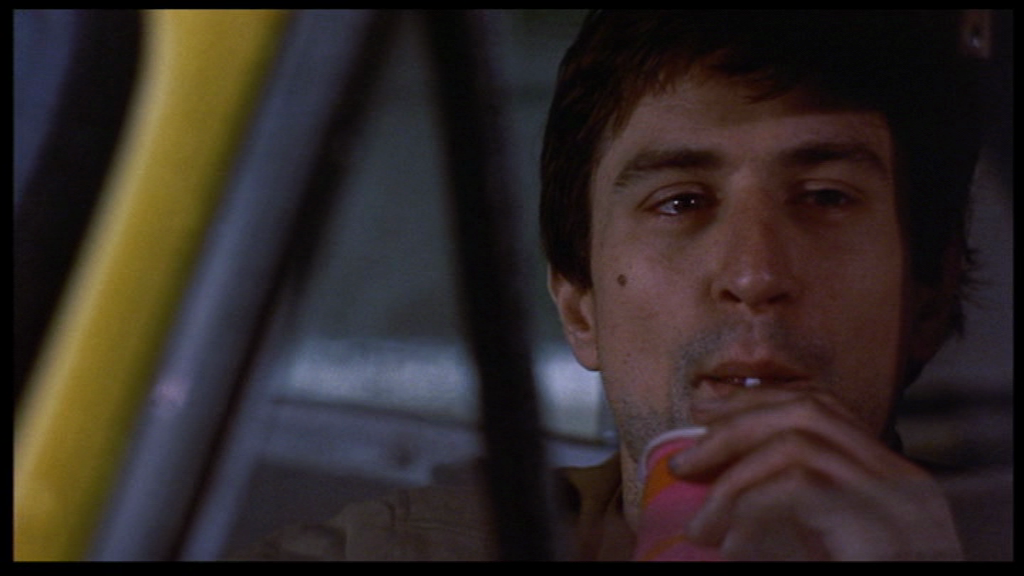

Prediction Confidence --> 0.9999665021896362
Predicted Class       --> Close-Up


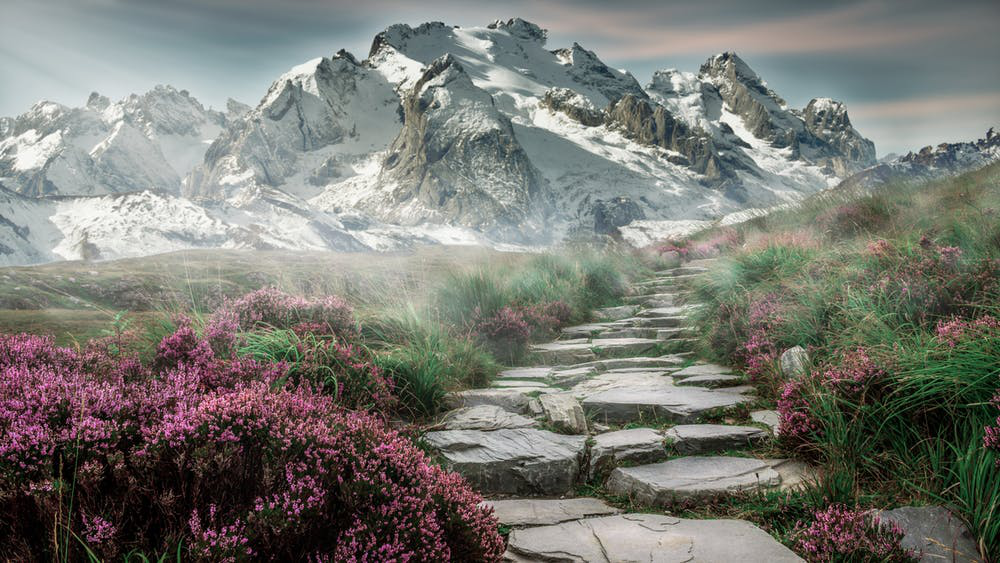

Prediction Confidence --> 1.0
Predicted Class       --> Extreme Wide


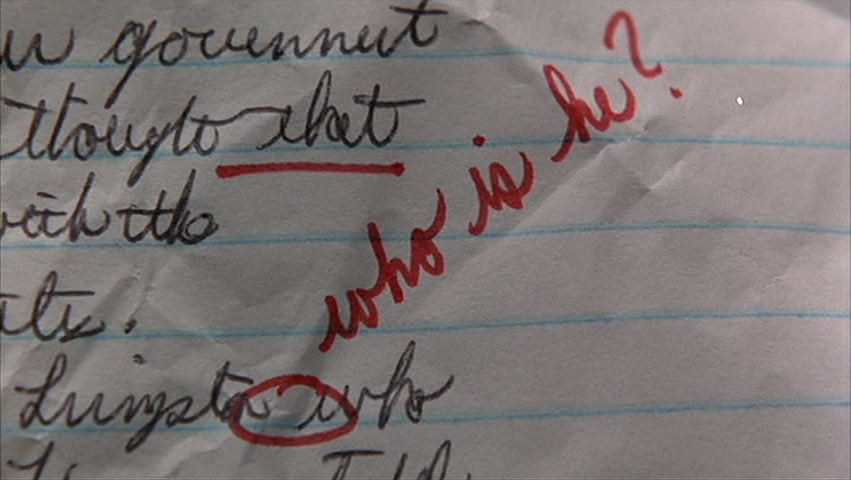

Prediction Confidence --> 0.8730176091194153
Predicted Class       --> Extreme Close-Up


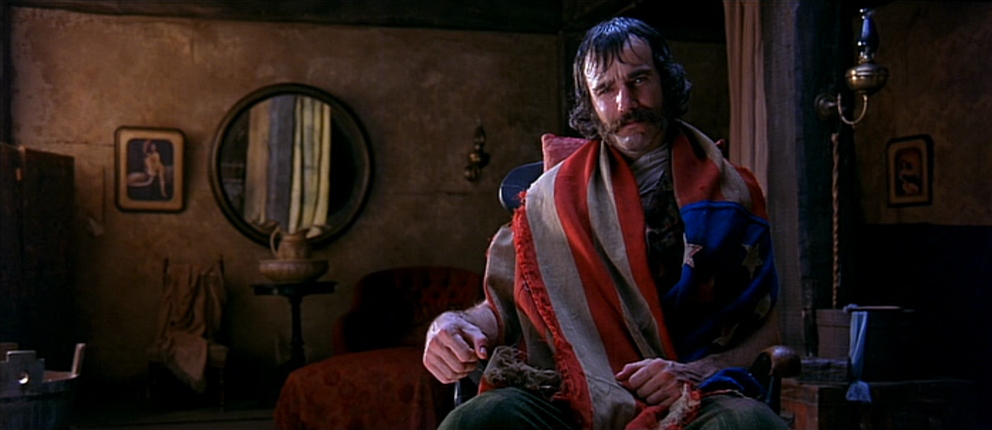

Prediction Confidence --> 0.9947804808616638
Predicted Class       --> Medium


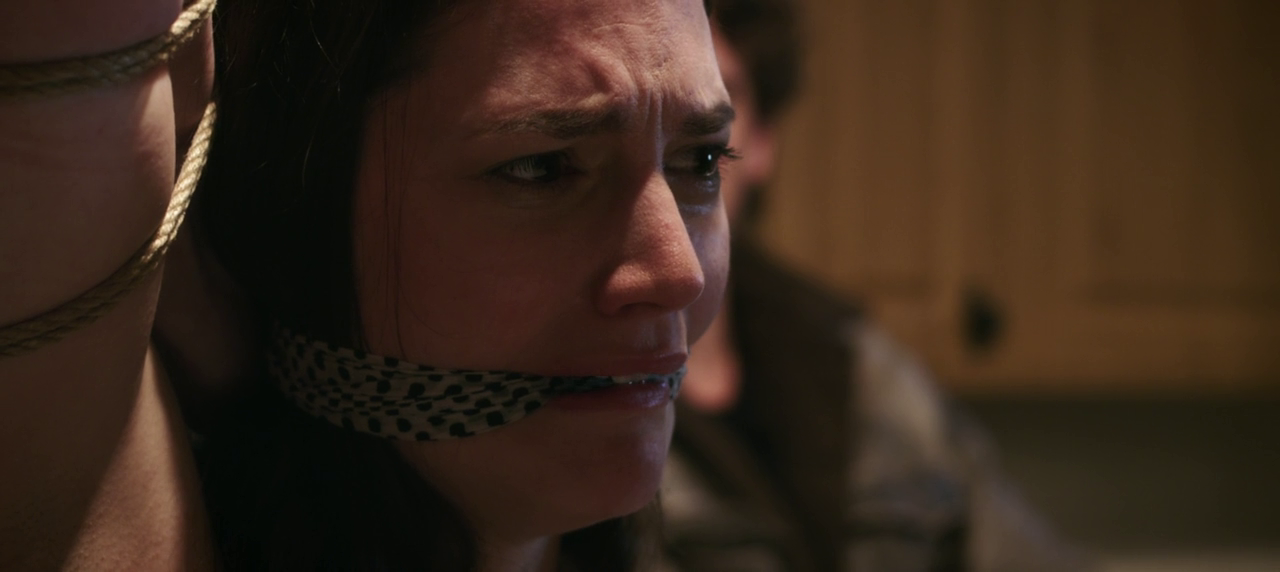

Prediction Confidence --> 0.9999942779541016
Predicted Class       --> Close-Up


In [7]:
# internally, the images get transformed to (224,224)

for sample in samples: 
    x = open_image(sample)
    x
    cat, _, preds = learn.predict(x)
    print(f'Prediction Confidence --> {preds[preds.argmax()]}')
    print(f'Predicted Class       --> {cat}')

## Inference: Feature Extraction + Head

Using `PIL` to read in the image and `torchvision.transform` to convert to a `torch.Tensor`

### Separate Model into Feature Extractor (`body`) and Head

In [8]:
len(learn.model)
body = learn.model[0]
head = learn.model[1]

2

In [9]:
body.eval();
head.eval();

### Inference

In [10]:
from PIL import Image
import torchvision.transforms.functional as TTF
import torch
import numpy as np

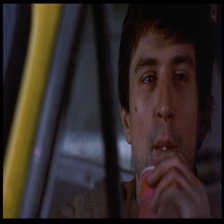

'Prediction Confidence --> 0.9599364399909973'

'Predicted Class       --> Close-Up'

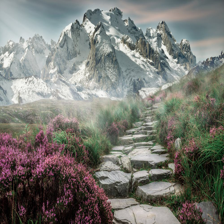

'Prediction Confidence --> 0.9997755885124207'

'Predicted Class       --> Extreme Wide'

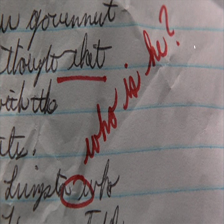

'Prediction Confidence --> 0.9972708821296692'

'Predicted Class       --> Extreme Close-Up'

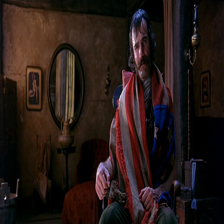

'Prediction Confidence --> 0.9875200986862183'

'Predicted Class       --> Medium'

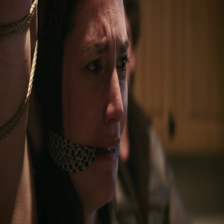

'Prediction Confidence --> 0.9914275407791138'

'Predicted Class       --> Close-Up'

In [11]:
softmax = nn.Softmax(dim=1)
for sample in samples:
    image = Image.open(sample).resize((224,224)).convert('RGB')
    image
    x = TTF.to_tensor(image).unsqueeze(0).cuda() # convert to normalised tensor
    
    feature   = body(x)
    raw_preds = head(feature)
    
    out = softmax(raw_preds)
    #f'Input Image Size               --> {x.shape}'
    #f'Feature Extractor Output Shape --> {feature.shape}'
    f'Prediction Confidence --> {out[0][out.argmax()]}'
    f'Predicted Class       --> {data.classes[out.argmax()]}'
    print()

### Feature Shape (matches a `tf`/`keras` `mobilenet_v2`)

In [12]:
feature.shape

torch.Size([1, 1280, 7, 7])

## Converting the Head to `Keras`/`Tf`

[SOURCE](https://nbviewer.jupyter.org/github/onnx/tutorials/blob/master/tutorials/PytorchTensorflowMnist.ipynb#Save-the-trained-model)

### Torch to ONNX

In [20]:
from CinemaNet.custom_head import *

In [21]:
torch.save(head.state_dict(), '/home/rahul/Desktop/head.pth')

In [23]:
# redefine model to avoid onnx troubles

learner = cnn_learner(data, models.mobilenet_v2)
head = learner.model[1]
head.load_state_dict(torch.load('/home/rahul/Desktop/head.pth'))

dummy_input = torch.rand(*feature.shape)

torch.onnx.export(head, dummy_input.cuda(), '/home/rahul/Desktop/head.onnx')

<All keys matched successfully>

### ONNX to TF

In [27]:
import onnx
from onnx_tf.backend import prepare

/home/rahul/onnx-tensorflow/onnx_tf/common/__init__.py:89: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)


In [103]:
head_onnx = onnx.load('/home/rahul/Desktop/head.onnx')
head_tf = prepare(head_onnx);
head_tf.export_graph('/home/rahul/Desktop/head.pb')

## Inference: `PyTorch` Feature Extractor + `TF` Head

In [92]:
def extract_features(fname,
                     body: torch.nn.Module,
                     input_size: tuple = (224,224),
                     return_img: bool  = True) -> np.array:
    'PyTorch Image Feature Extractor'
    from PIL import Image
    import torchvision.transforms.functional as TTF
    
    # read and preprocess
    img = Image.open(fname).convert('RGB')
    plt.show(img)
    x = TTF.to_tensor(img.resize(input_size)).unsqueeze(0)
    
    # move to the right device (CPU | GPU)
    if torch.cuda.is_available(): x,body = x.cuda(),body.cuda()
    else: x,body = x.cpu(), body.cpu()
       
    # return image without resizing
    if return_img: return img, body(x).cpu().data.numpy()
    else: return body(x).cpu().data.numpy()

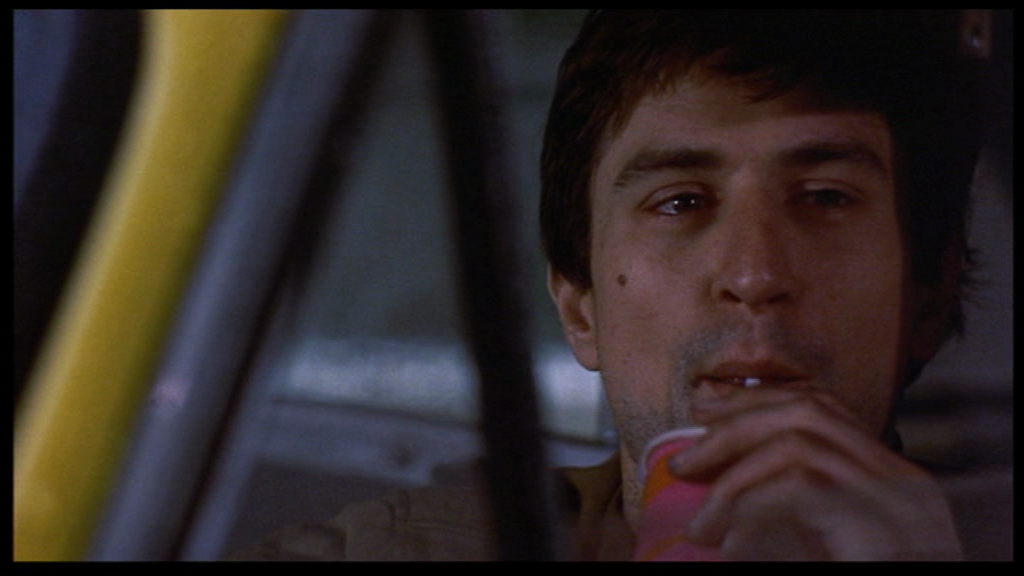

Prediction Class      --> Close-Up
Prediction Confidence -->  95.99 %



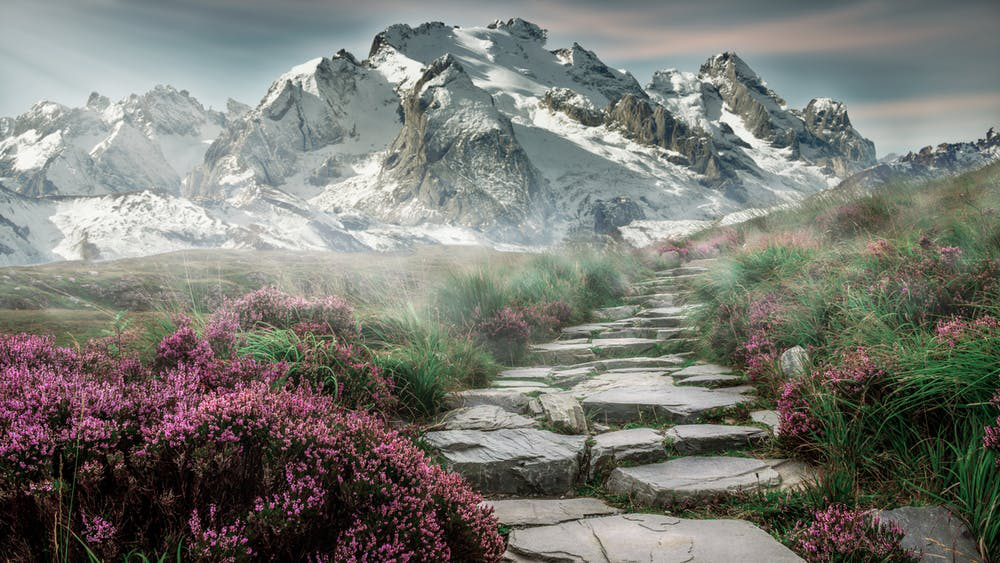

Prediction Class      --> Extreme Wide
Prediction Confidence -->  99.98 %



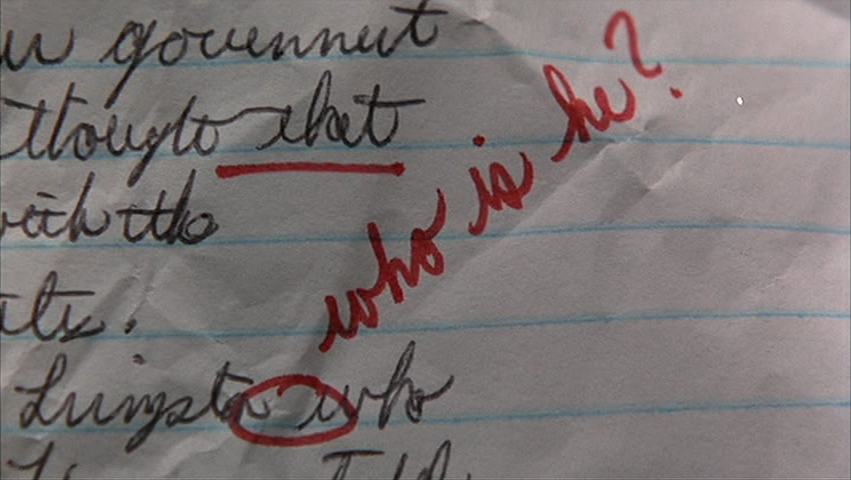

Prediction Class      --> Extreme Close-Up
Prediction Confidence -->  99.73 %



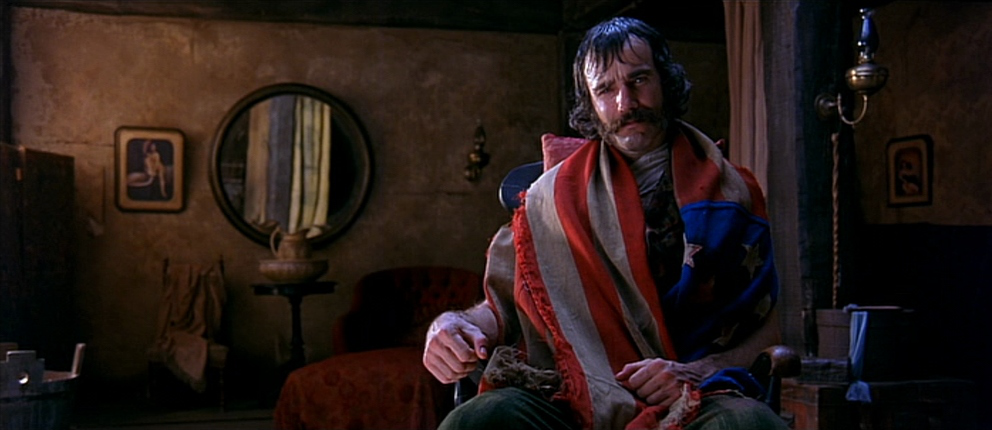

Prediction Class      --> Medium
Prediction Confidence -->  98.75 %



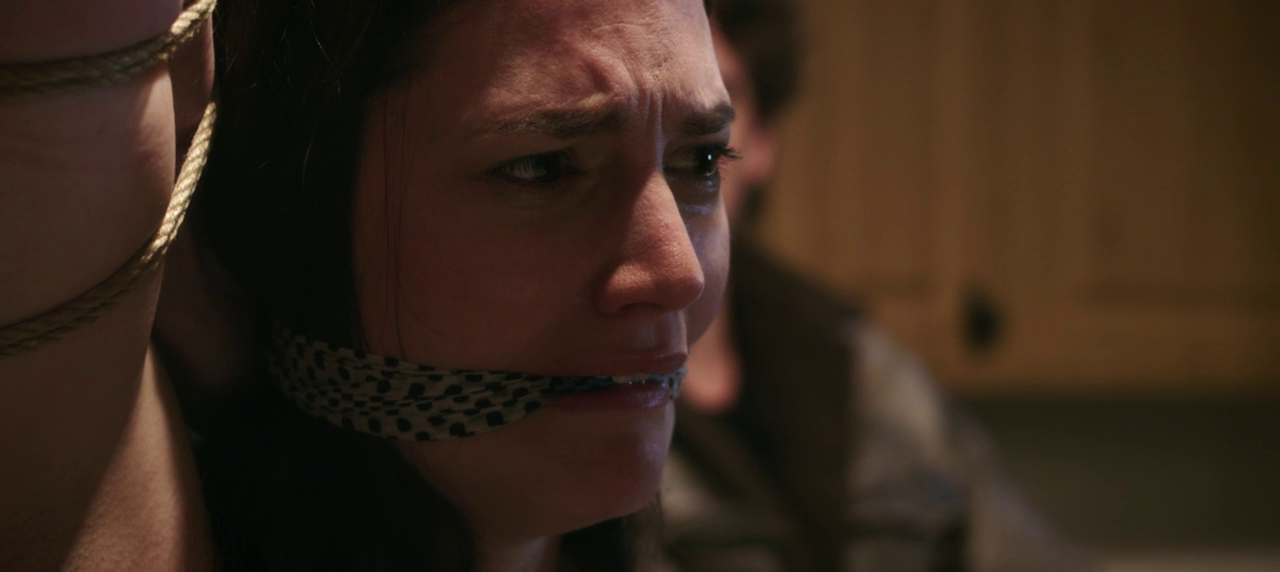

Prediction Class      --> Close-Up
Prediction Confidence -->  99.14 %



In [102]:
for sample in samples:
    img, features = extract_features(sample, body)
    img
    output = tf_rep.run(features)
    output = F.softmax(torch.tensor(output[0][0]), dim=-1) # not essential
    print(f'Prediction Class      --> {data.classes[output.argmax()]}')
    print(f'Prediction Confidence --> {output[output.argmax()]*100: .02f} %')
    print()

## Inference: `TF` Feature Extractor + `TF` Head

In [142]:
import tensorflow as tf

In [143]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(3, 224, 224),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [145]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [147]:
# SRC: https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1

img = image.load_img(samples[0], target_size=(224,224))
x   = image.img_to_array(img)
x   = np.expand_dims(x, axis=0)
x   = preprocess_input(x)

In [148]:
tf_features = base_model.predict(x)

UnimplementedError:  The Conv2D op currently only supports the NHWC tensor format on the CPU. The op was given the format: NCHW
	 [[node mobilenetv2_1.00_224/Conv1/Conv2D (defined at <ipython-input-148-caae965b74a8>:1) ]] [Op:__inference_distributed_function_20395]

Function call stack:
distributed_function


In [149]:
tf.test.is_gpu_available()

False

In [141]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17228450190923630740
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5373879561015618493
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14476015602503403573
physical_device_desc: "device: XLA_GPU device"
]
